# Import packages

In [1]:
%matplotlib inline
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt  
import seaborn as sns

import random

import util

import string
import spacy
from spacy.lang.en import English
import en_core_web_md
from spacy import displacy
from sklearn.metrics.pairwise import cosine_similarity

#Topic Modeling
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore") #category=DeprecationWarning

# Explore Data

In [2]:
df = util.read_df('../data/samples.csv')

In [3]:
df.dtypes

Unnamed: 0             object
InBoundCreatedAT       object
InBound                object
OutBound               object
TemplateID            float64
TemplateMessage        object
TemplateStoreID       float64
ConversationID        float64
StoreID               float64
ConversationType      float64
ConversationLength    float64
PreviousMessages       object
label                  object
body                   object
outbound_tokens        object
template_tokens        object
template_distance     float64
dtype: object

In [4]:
#Date time
df['time'] = pd.to_datetime(df['InBoundCreatedAT'])
df['hour'] = df['time'].map(lambda x: x.hour)

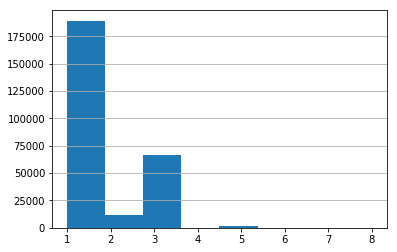

In [5]:
df.ConversationType.hist(bins = 8)
plt.grid(axis = 'x')
plt.show()

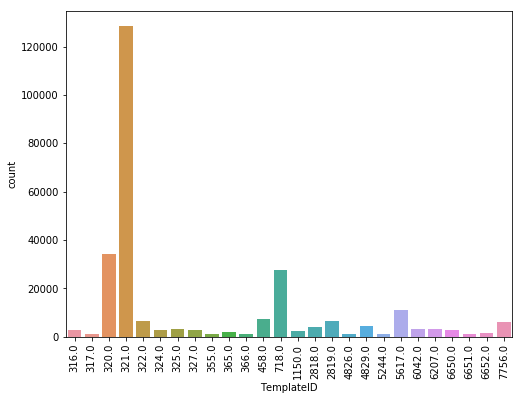

There are 26 unique Templates


In [6]:
#df.groupby('TemplateID').InBound.count().plot(kind='bar')
plt.figure (figsize = (8,6))
fig = sns.countplot(df['TemplateID'] )
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
plt.show()
print("There are {0} unique Templates".format(len(df.TemplateID.unique())))

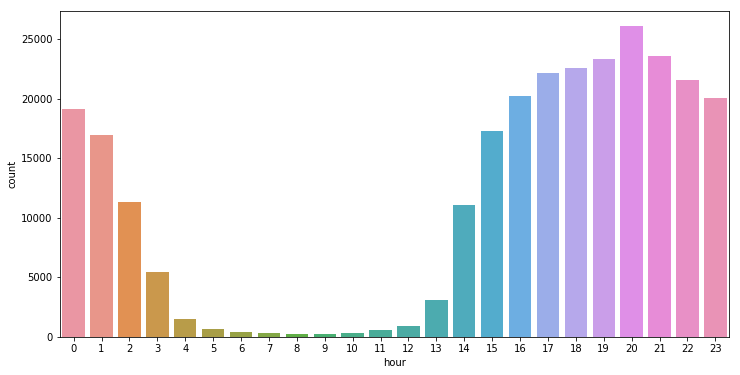

In [7]:
plt.figure(figsize = (12,6))
#sns.distplot(df.hour, kde = False)
fig = sns.countplot(df['hour'] )
#plt.xticks(range(24))
plt.show()

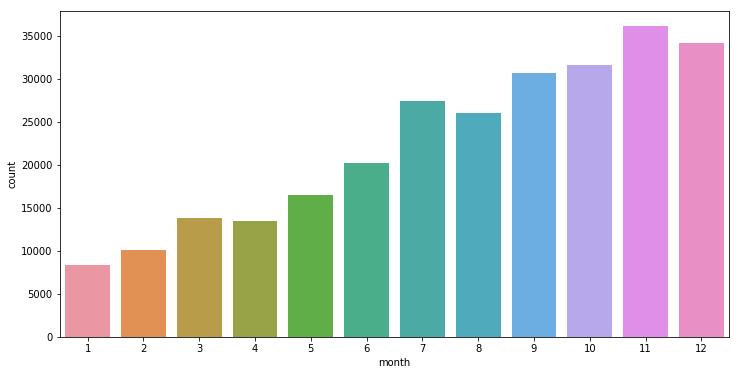

In [8]:
plt.figure(figsize = (12,6))
df['month'] = df['time'].map(lambda x: x.month)
fig = sns.countplot(df['month'] )
plt.show()

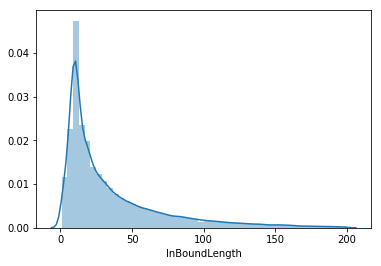

In [9]:
df['InBoundLength']=df['InBound'].apply(len)
sns.distplot(df.loc[df['InBoundLength'] < 200,'InBoundLength'])

plt.show()

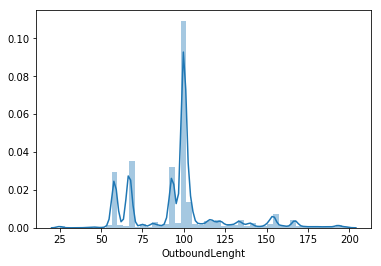

In [10]:
#outbound
df['OutboundLenght'] = df['OutBound'].apply(len)
#df['OutboundLenght'].hist()
sns.distplot(df.loc[df['OutboundLenght'] < 200,'OutboundLenght'])
plt.show()

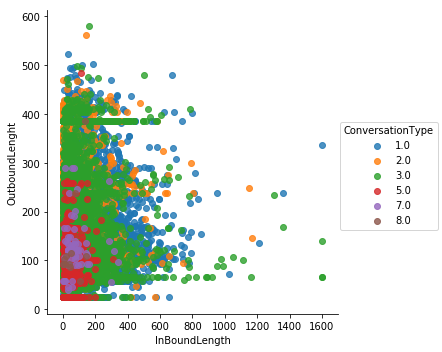

In [11]:
sns.lmplot(x='InBoundLength', y='OutboundLenght', data=df , hue = 'ConversationType', fit_reg=False, )
plt.show()

# Explore Text

In [13]:
#! pip install spacy
#!python -m spacy download en_core_web_md
#!pip install gensim
#!pip install pyLDAvis
#!pip install WordCloud

In [14]:
nlp = spacy.load('en_core_web_md')
# nlp = en_core_web_md.load()

In [15]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(stop_words))
print('First ten stop words: %s' % list(stop_words)[:10])

Number of stop words: 326
First ten stop words: ['became', 'hence', 'after', 'rather', 'your', 'did', 'front', 'by', 'often', 'thence']


## Visualize dependencies and entities

In [22]:
def nlp_doc(specific_class = False , class_no = None):
    if specific_class:
        doc = df.loc[df.TemplateID == class_no, ['InBound']].sample(1).values[0]
        doc = nlp (np.array2string(doc))
    else:
        doc = df['InBound'].sample(1).values[0]
        doc = nlp (doc)
    return doc

In [71]:
msg = nlp_doc()
print('Entities in the message:')

# for ent in msg.ents:
#     print(ent.text, ent.label_)
displacy.render(msg, style="ent")

Entities in the message:


In [76]:
another_msg = nlp_doc()

displacy.render(another_msg, style="dep")

In [79]:
for word in another_msg:
    print(word)
    print(list(word.ancestors))

Can
[FaceTime]
we
[FaceTime]
FaceTime
[]
.
[FaceTime]
I
[need]
need
[]
to
[need]
k
[to, need]
ow
[need]
more
[need]


### Cosine Similarity

In [80]:
doc1 = nlp_doc(specific_class = True , class_no = 327)
doc2 = nlp_doc(specific_class = True , class_no = 327)
doc3 = nlp_doc(specific_class = True , class_no = 320)

#print(np.dot(doc1.vector, doc2.vector) / (np.linalg.norm(doc1.vector) * np.linalg.norm(doc2.vector)))
print("Cosine Similarity betwee to message in same class: {0:.3f}".format( doc1.similarity(doc2)))
print("Cosine Similarity betwee to message in different classes :{0:.3f}".format(doc1.similarity(doc3)))

Cosine Similarity betwee to message in same class: 0.965
Cosine Similarity betwee to message in different classes :0.678


---

# Topic Modeling

In [84]:
samples = pd.read_csv('../data/topicModeling_2000samples.csv')
samples['InboundClean'] = samples['InBound'].apply(util.spacy_tokenizer)
samples['InboundClean'] = samples['InboundClean'].apply(' '.join)

In [85]:
# Create Dictionary
id2word = corpora.Dictionary(samples['InboundClean'].apply(lambda x: x.split()))

# Create Corpus
texts = samples['InboundClean'].apply(lambda x: x.split())

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [86]:
def lda(num_topics = 10):
    model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    return model

In [87]:
# Visualize the topics
def vis_lda(model):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
    return vis

In [88]:
# Build LDA model
lda_model = lda(num_topics = 26) #There are 26 different templates

In [89]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(15,
  '0.001*"now-" + 0.001*"agreed" + 0.001*"august" + 0.001*"doubles" + '
  '0.001*"mission" + 0.001*"night" + 0.001*"sooooo" + 0.001*"heaps" + '
  '0.001*"system" + 0.001*"massive"'),
 (25,
  '0.076*"week" + 0.001*"got" + 0.001*"ebay" + 0.001*"update" + '
  '0.001*"movement" + 0.001*"dawn" + 0.001*"communication" + 0.001*"443212" + '
  '0.001*"katie" + 0.001*"wanted"'),
 (21,
  '0.012*"information" + 0.006*"bet" + 0.001*"ight" + 0.001*"delete" + '
  '0.001*"🏼" + 0.001*"jennifer" + 0.001*"👍" + 0.001*"now-" + 0.001*"sooooo" + '
  '0.001*"agreed"'),
 (10,
  '0.132*"️" + 0.049*"happy" + 0.045*"❤" + 0.005*"holidays" + 0.000*"♀" + '
  '0.000*"🇺" + 0.000*"🏃" + 0.000*"running" + 0.000*"🎶" + 0.000*"🇸"'),
 (2,
  '0.116*"phone" + 0.101*"15" + 0.063*"maybe" + 0.043*"applied" + '
  '0.042*"ready" + 0.000*"like" + 0.000*"sara" + 0.000*"right" + '
  '0.000*"refund" + 0.000*"ordering"'),
 (6,
  '0.232*"buy" + 0.084*"today" + 0.052*"25" + 0.037*"apply" + 0.000*"😁" + '
  '0.000*"work" + 0.000*"item

In [90]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=samples['InboundClean'].apply(lambda x: x.split()), dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -17.361838375638786

Coherence Score:  0.468503607777025


In [91]:
vis = vis_lda(lda_model)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.320653  0.222399       1        1  14.518695
0      0.257654 -0.319456       2        1  10.499833
17     0.197990  0.128725       3        1   9.837919
24     0.060091  0.055118       4        1   7.025138
14     0.017108  0.033865       5        1   5.116369
1      0.015934  0.033215       6        1   4.855485
7      0.016815  0.034686       7        1   4.767565
8      0.017668  0.033658       8        1   4.519380
18     0.060486  0.053813       9        1   4.234479
11    -0.011049  0.022911      10        1   4.033301
19     0.119336 -0.257133      11        1   3.860950
4     -0.026882  0.015552      12        1   3.858811
12    -0.007763  0.023002      13        1   3.015587
20    -0.063674  0.001371      14        1   2.872987
9     -0.043179  0.009177      15        1   2.735395
13    -0.069624 -0.000870      16        1   2.535754
5     -0.070227 -0.001190      17        1   2.526406
16    -0.054056  0.004795      18        1   1.846003
23    -0.080558 -0.005534      19        1   1.484790
22    -0.085664 -0.007574      20        1   1.386615
2     -0.093167 -0.011039      21        1   1.318311
6     -0.090723 -0.009867      22        1   1.206635
10    -0.096753 -0.013495      23        1   0.877797
25    -0.097089 -0.015047      24        1   0.423977
21    -0.096741 -0.015492      25        1   0.368986
15    -0.096586 -0.015589      26        1   0.272826, topic_info=    Category         Freq            Term        Total  loglift  logprob
25   Default  1023.000000           thank  1023.000000  30.0000  30.0000
16   Default   700.000000          thanks   700.000000  29.0000  29.0000
40   Default   420.000000             not   420.000000  28.0000  28.0000
26   Default   278.000000              no   278.000000  27.0000  27.0000
61   Default   177.000000              ok   177.000000  26.0000  26.0000
38   Default   264.000000              do   264.000000  25.0000  25.0000
57   Default   191.000000           order   191.000000  24.0000  24.0000
51   Default   188.000000             can   188.000000  23.0000  23.0000
48   Default   134.000000            stop   134.000000  22.0000  22.0000
143  Default   100.000000        shipping   100.000000  21.0000  21.0000
49   Default    97.000000         texting    97.000000  20.0000  20.0000
101  Default    82.000000             yes    82.000000  19.0000  19.0000
76   Default    72.000000            okay    72.000000  18.0000  18.0000
11   Default   103.000000           sarah   103.000000  17.0000  17.0000
56   Default    87.000000            code    87.000000  16.0000  16.0000
161  Default    77.000000         ordered    77.000000  15.0000  15.0000
4    Default    97.000000              hi    97.000000  14.0000  14.0000
72   Default   113.000000          number   113.000000  13.0000  13.0000
54   Default    70.000000        discount    70.000000  12.0000  12.0000
170  Default    62.000000        purchase    62.000000  11.0000  11.0000
129  Default    66.000000           going    66.000000  10.0000  10.0000
189  Default    52.000000         awesome    52.000000   9.0000   9.0000
150  Default    51.000000            good    51.000000   8.0000   8.0000
106  Default    37.000000               2    37.000000   7.0000   7.0000
187  Default    36.000000            need    36.000000   6.0000   6.0000
30   Default    43.000000            list    43.000000   5.0000   5.0000
183  Default    35.000000             ...    35.000000   4.0000   4.0000
144  Default    42.000000      appreciate    42.000000   3.0000   3.0000
114  Default    41.000000           wrong    41.000000   2.0000   2.0000
100  Default    60.000000            want    60.000000   1.0000   1.0000
..       ...          ...             ...          ...      ...      ...
524  Topic26     0.013199        buisness     1.178105   1.4126  -7.4254
633  Topic26     0.013199         su

### 4 Topics

In [97]:
lda_model_4topics = lda(num_topics = 4)
vis = vis_lda(lda_model_4topics)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.310256  0.037893       1        1  31.928995
0      0.149780  0.222840       2        1  28.671021
2      0.084516 -0.212175       3        1  22.694603
1      0.075960 -0.048558       4        1  16.705379, topic_info=    Category        Freq        Term       Total  loglift  logprob
25   Default  570.000000       thank  570.000000  30.0000  30.0000
16   Default  387.000000      thanks  387.000000  29.0000  29.0000
40   Default  232.000000         not  232.000000  28.0000  28.0000
26   Default  159.000000          no  159.000000  27.0000  27.0000
38   Default  137.000000          do  137.000000  26.0000  26.0000
61   Default  142.000000          ok  142.000000  25.0000  25.0000
48   Default  102.000000        stop  102.000000  24.0000  24.0000
51   Default  108.000000         can  108.000000  23.0000  23.0000
49   Default   74.000000     texting   74.000000  22.0000  22.0000
143  Default   54.000000    shipping   54.000000  21.0000  21.0000
56   Default   47.000000        code   47.000000  20.0000  20.0000
72   Default   53.000000      number   53.000000  19.0000  19.0000
76   Default   70.000000        okay   70.000000  18.0000  18.0000
161  Default   42.000000     ordered   42.000000  17.0000  17.0000
4    Default   48.000000          hi   48.000000  16.0000  16.0000
101  Default   60.000000         yes   60.000000  15.0000  15.0000
170  Default   38.000000    purchase   38.000000  14.0000  14.0000
240  Default   29.000000       check   29.000000  13.0000  13.0000
348  Default   27.000000          :)   27.000000  12.0000  12.0000
54   Default   40.000000    discount   40.000000  11.0000  11.0000
57   Default  107.000000       order  107.000000  10.0000  10.0000
189  Default   32.000000     awesome   32.000000   9.0000   9.0000
144  Default   24.000000  appreciate   24.000000   8.0000   8.0000
129  Default   36.000000       going   36.000000   7.0000   7.0000
511  Default   33.000000        card   33.000000   6.0000   6.0000
400  Default   33.000000         did   33.000000   5.0000   5.0000
100  Default   31.000000        want   31.000000   4.0000   4.0000
187  Default   20.000000        need   20.000000   3.0000   3.0000
183  Default   20.000000         ...   20.000000   2.0000   2.0000
66   Default   32.000000           u   32.000000   1.0000   1.0000
..       ...         ...         ...         ...      ...      ...
240   Topic4   28.631023       check   29.321762   1.7656  -3.8579
348   Topic4   27.117937          :)   27.782116   1.7652  -3.9122
144   Topic4   24.145176  appreciate   24.807076   1.7624  -4.0283
187   Topic4   20.210178        need   20.886875   1.7565  -4.2062
183   Topic4   19.657896         ...   20.334377   1.7556  -4.2339
703   Topic4   16.545870        cost   17.204195   1.7504  -4.4063
160   Topic4   15.868581        free   16.523222   1.7490  -4.4481
120   Topic4   14.601806        long   15.265115   1.7450  -4.5313
686   Topic4   14.769599        went   15.442286   1.7449  -4.5198
359   Topic4   14.942625           😁   15.636321   1.7441  -4.5082
261   Topic4   13.885743        love   14.543638   1.7431  -4.5815
269   Topic4   13.499815        guys   14.168598   1.7411  -4.6097
252   Topic4   12.966060       think   13.656451   1.7376  -4.6501
60    Topic4   11.536175         way   12.187790   1.7345  -4.7669
87    Topic4   12.013680           😊   12.727344   1.7317  -4.7264
116   Topic4   11.724516       black   12.438534   1.7303  -4.7507
188   Topic4   10.851960         new   11.519708   1.7297  -4.8281
207   Topic4    9.034114           ️    9.673557   1.7211  -5.0114
302   Topic4    8.438354        case    9.083993   1.7157  -5.0796
532   Topic4    9.110867      couple    9.830790   1.7134  -5.0029
407   Topic4    8.138256        sale    8.790726   1.7123  -5.1158
728   Topic4    8.832195    reaching    9.560730   1.7102  -5.0340
844   Topic4   

# Word Cloud

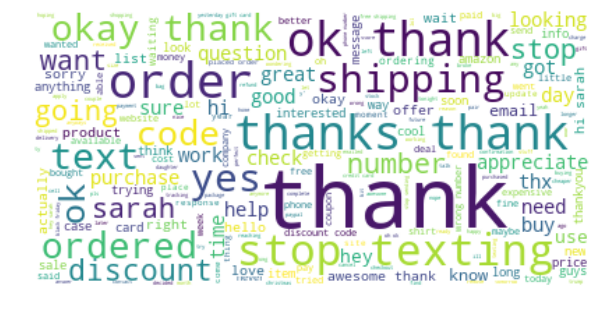

In [94]:
# whole text
text = ' '.join(samples['InboundClean'])

# Generate a word cloud image
wordcloud = WordCloud(background_color="white" , max_font_size=60, contour_width=3, contour_color='steelblue').generate(text)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()